# Use Pandas to sort and cluster seismic event arrivals CSV files

##  Fei Zhang
### 2018-06-07

190

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
inputcsv = '/g/data/ha3/fxz547/Githubz/passive-seismic/tests/testdata/100K_ensemble.p.txt'
csv_data = pd.read_csv(inputcsv, sep='\s+', header='infer')

In [7]:
csv_data.head()

,#eventID,originTimestamp,mag,originLon,originLat,originDepthKm,net,sta,cha,pickTimestamp,...,az,baz,distance,ttResidual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma
0,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,KNA,BHZ,1.197052e+09,...,232.647636,55.399525,18.838486,-0.134955,0.0,0.0,0.0,0.0,0,0
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,QLP,BHZ,1.197052e+09,...,179.947115,359.941088,21.923102,1.734943,0.0,0.0,0.0,0.0,0,0
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,RMQ,BHZ,1.197052e+09,...,169.186187,347.946731,22.255710,3.240389,0.0,0.0,0.0,0.0,0,0
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,WSI,BHZ,1.197052e+09,...,256.588695,79.595928,24.286730,-0.985012,0.0,0.0,0.0,0.0,0,0
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,ARMA,BHZ,1.197052e+09,...,165.616858,343.327251,26.681831,2.491256,0.0,0.0,0.0,0.0,0,0


In [11]:
from seismic.traveltime.cluster_grid import Grid2
import seismic.traveltime.sort_rays as sortrays

In [13]:
column_name_map={
    "originLon": "source_lon",
    "originLat": "source_lat",
    "originDepthKm":"source_depth_km",
    "stationLon": "station_lon",
    "stationLat": "station_lat",
    "ttResidual":  "tt_residual"
}

csv_data.rename(columns=column_name_map, inplace=True)

csv_data = sortrays.apply_filters(csv_data, "P")

The initial CSV size= (99999, 24)
After residual cutoff, CSV size= (91229, 24)
After qualityMeasureCWT, CSV size= (84442, 24)
After qualityMeasureSlope, CSV size= (82639, 24)
After nSigma, CSV size= (82551, 24)
Final Number of P Rays =  82551 ['AU_KNA_smi:local/102160r49', 'IR_QLP_smi:local/102160r49', 'AU_RMQ_smi:local/102160r49', 'GE_WSI_smi:local/102160r49', 'GE_ARMA_smi:local/102160r49']


In [15]:
csv_data.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,baz,distance,tt_residual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma,manual_picks_flag
0,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,KNA,BHZ,1.197052e+09,...,55.399525,18.838486,-0.134955,0.0,0.0,0.0,0.0,0,0,1
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,QLP,BHZ,1.197052e+09,...,359.941088,21.923102,1.734943,0.0,0.0,0.0,0.0,0,0,1
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,RMQ,BHZ,1.197052e+09,...,347.946731,22.255710,3.240389,0.0,0.0,0.0,0.0,0,0,1
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,WSI,BHZ,1.197052e+09,...,79.595928,24.286730,-0.985012,0.0,0.0,0.0,0.0,0,0,1
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,ARMA,BHZ,1.197052e+09,...,343.327251,26.681831,2.491256,0.0,0.0,0.0,0.0,0,0,1


In [16]:
mygrid = Grid2(param_file="/g/data/ha3/fxz547/Githubz/passive-seismic/seismic/traveltime/param1x1")


In [24]:
import ellipcorr

from obspy.geodetics import gps2dist_azimuth, locations2degrees
import logging
from seismic.traveltime import pslog
from seismic.traveltime.cluster_grid import Grid2

# DPI = asin(1.0) / 90.0
# R2D = 90. / asin(1.)
# FLOAT_FORMAT = '%.4f'

log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

def compute_ellipticity_corr(arrival_phase, ev_latitude, ev_longitude, ev_depth_km, sta_latitude, sta_longitude,
                             degrees_to_source):
    """
    Utility function to compute ellipticity correction.

    :param arrival_phase: P or S
    :param ev_latitude:  event lat
    :param ev_longitude: event long
    :param ev_depth_km: event depth in km
    :param sta_latitude: station lat
    :param sta_longitude: station long
    :param degrees_to_source: degree to source
    :return: ellipticity correction float value
    """
    myazim = gps2dist_azimuth(ev_latitude, ev_longitude, sta_latitude, sta_longitude)[1]  # [1] shall be taken
    # see https://docs.obspy.org/_modules/obspy/geodetics/base.html#gps2dist_azimuth
    # this function returns 3 values (Great_circle_distance_in_m, azimuth_A->B_in_degrees, azimuth_B->A_in degrees)

    log.debug("Check input params to ellipticity_corr = %s, %s, %s, %s, %s", arrival_phase, degrees_to_source,
              ev_depth_km, 90 - ev_latitude, myazim)

    ellipticity_corr = ellipcorr.ellipticity_corr(
        phase=arrival_phase,
        edist=degrees_to_source,
        edepth=ev_depth_km,
        ecolat=90 - ev_latitude,  # conversion to co-latitude
        azim=myazim
    )

    log.debug("ellipticity_corr = %s", ellipticity_corr)

    return ellipticity_corr


def sort_cluster(csv_data, phase, outputcsv):
    
    
    csv_data['source_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.source_lat, x.source_lon, 1000 * (x.source_depth_km))[0], axis=1)

    csv_data['station_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.station_lat, x.station_lon, 0.0)[0], axis=1)

    csv_data['observed_tt'] = csv_data.pickTimestamp - csv_data.originTimestamp

    # cluster_data.to_csv(outputcsv+"_debug.CSV", header=True, index=False, sep=',')

    log.info('Begin Sorting arrivals.')

    # groupby automatically sorts
    med = csv_data.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(csv_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True, right_index=True)

    # use the following to keep only unique  prim_key: ['source_block', 'station_block']
    # final_df.drop_duplicates(subset=['source_block', 'station_block'],keep='first', inplace=True)
    # Note that some near-by stations may be cluster into one station_block_number, if want to keep stations try
    # final_df.drop_duplicates(subset=['source_block', 'station_block', 'station_code'],keep='first', inplace=True)

    final_df.drop_duplicates(subset=['source_block', 'station_block'], keep='first', inplace=True)

    # elliptic correction to the  observed_travel_time;

    final_df['locations_to_degrees'] = final_df.apply(lambda x: locations2degrees(x.source_lat, x.source_lon,
                                                                                  x.station_lat, x.station_lon), axis=1)
    final_df['my_azim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                    x.station_lat, x.station_lon)[1], axis=1)

    final_df['my_bazim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                     x.station_lat, x.station_lon)[2], axis=1)
    final_df['ellipticity_corr'] = final_df.apply(lambda x:
                                                  compute_ellipticity_corr(phase, x.source_lat, x.source_lon,
                                                                           x.source_depth_km,
                                                                           x.station_lat, x.station_lon, x.distance),
                                                  axis=1)

    final_df['observed_tt'] = final_df.observed_tt + final_df.ellipticity_corr

    # make sure the originDepth/source_depth is in KM for required by inversion program

    final_df.to_csv(outputcsv, header=True, index=False, sep=',')  # use comma separator,

    # inpdf.to_csv(outputcsv, header=True, index=False, sep=' ')   # mismatch columns in space-delimited csv file as the NaN => empty space !

    if phase == 'P':
        final_df['P_or_S'] = 1
    elif phase == 'S':
        final_df['P_or_S'] = 2
    else:
        raise Exception("Phase must be P or S !!!")

    final_df['event_number'] = final_df.apply(lambda x: int(x.originTimestamp), axis=1)

    # the following values are required for inversion program. the event_number defined as int(originTimestamp)
    # the columns must be in the order:
    required_columns = ['source_block', 'station_block', 'tt_residual', 'event_number',
                        'source_lon', 'source_lat', 'source_depth_km',
                        'station_lon', 'station_lat', 'observed_tt', 'locations_to_degrees', 'P_or_S']

    pdf4inv = final_df[required_columns]

    inv_txt = "%s_inv.txt" % outputcsv
    pdf4inv.to_csv(inv_txt, header=False, index=False, sep=' ', float_format='%.6f')  # space delimitted txt file

    print("Output CSV files = ",outputcsv, inv_txt)
    
    return (final_df, pdf4inv)

In [25]:
pdf1, pdf4 = sort_cluster(csv_data, "P", "P_sort_cluster.csv")

Output CSV files =  P_sort_cluster.csv P_sort_cluster.csv_inv.txt


In [26]:
pdf1.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,manual_picks_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
63889,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,II,TAU,BHZ,1.283532e+09,...,0,17085,17216,252.512430,17.937228,262.955847,99.962177,-0.147570,1,1283531746
63619,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,GE,TOO,BHZ,1.283532e+09,...,1,17085,19192,281.680508,20.873575,277.029864,114.428774,-0.119492,1,1283531746
63612,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,AU,MILA,SHZ,1.283532e+09,...,1,17085,19379,255.151508,18.472694,282.169796,117.047407,-0.108492,1,1283531746
63614,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,G,CAN,S?Z,1.283532e+09,...,1,17085,19919,263.659579,19.431021,286.622725,121.350719,-0.100421,1,1283531746
63613,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.37618,2.098619,GE,CNB,BHZ,1.283532e+09,...,1,17085,19920,263.280446,19.182147,287.112210,121.602233,-0.099554,1,1283531746


In [28]:
pdf4.head()

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
63889,17085,17216,0.949630,1283531746,171.984919,-43.37618,2.098619,147.3200,-42.9089,252.512430,17.937228,1
63619,17085,19192,-1.956863,1283531746,171.984919,-43.37618,2.098619,145.4906,-37.5714,281.680508,20.873575,1
63612,17085,19379,-2.337215,1283531746,171.984919,-43.37618,2.098619,149.1550,-37.0539,255.151508,18.472694,1
63614,17085,19919,-4.291272,1283531746,171.984919,-43.37618,2.098619,148.9990,-35.3203,263.659579,19.431021,1
63613,17085,19920,-1.852497,1283531746,171.984919,-43.37618,2.098619,149.3629,-35.3124,263.280446,19.182147,1


In [ ]:
# how about do the cluster sort again?

In [2]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'SNR', 'P_or_S']

def sort(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on median of observed travel time.

    If there are multiple source and station block combinations, we keep the
    row corresponding to the median observed travel time (observed_tt).

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: None
    """

#     log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

#     log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(by=['source_block',
                                   'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block',
                                     'event_number', SOURCE_LONGITUDE,
                                     SOURCE_LATITUDE, 'source_depth'],
                             keep='first',
                             inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df


In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:
inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'

residual_cutoff=10.0
sortedfile='sortedfile_S.csv'
sortedfile2= 'sortedfile2_S.csv'

inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/seismic_events_arrivals_P_0.csv'
inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/tempworks/outfile_P.csv'
residual_cutoff=5.0
sortedfile='sortedfile_P.csv'
sortedfile2= 'sortedfile2_P.csv'


In [5]:
finalpdf = sort(inputcsv,sortedfile,residual_cutoff)

In [6]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
49650,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
26347,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
23276,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
8850,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
33158,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [7]:
#sort again
pdf2=sort(sortedfile, sortedfile2, residual_cutoff )

In [8]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
0,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
1,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
2,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
3,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
4,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [9]:
pdf2.shape

(23460, 14)

In [10]:
finalpdf.shape


(23460, 14)

<Figure size 432x288 with 0 Axes>

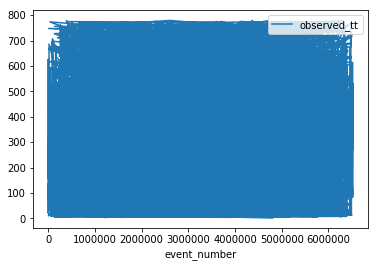

In [11]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

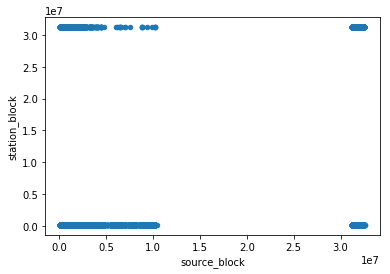

In [12]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

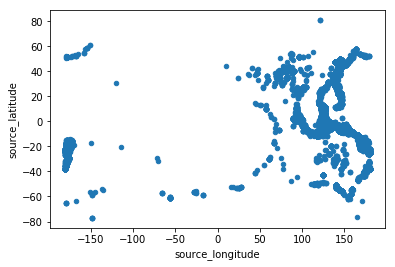

In [13]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

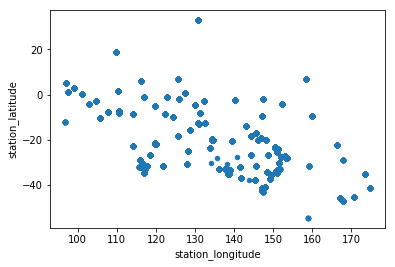

In [14]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')

In [15]:
 med = pdf2.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [16]:
med.head()

,source_block,station_block,observed_tt
0,130364,31202939,11.006560
1,130833,180555,425.172023
2,131166,158938,304.204034
3,131214,156024,263.530413
4,132662,166565,354.924562


In [17]:
med.shape

(23460, 3)

In [18]:
med2 = pdf2.groupby(
        by=['source_block', 'station_block'] )['SNR'].max().reset_index() # use a seq index:0,1,2,.

In [19]:
med2.head()

,source_block,station_block,SNR
0,130364,31202939,49.615829
1,130833,180555,13.547856
2,131166,158938,12.414057
3,131214,156024,332.555463
4,132662,166565,9.582778


In [20]:
med2.shape

(23460, 3)

In [21]:
pdf2.shape

(23460, 14)

In [22]:
pdf3=pdf2.groupby(by=['source_block', 'station_block']).count()

In [23]:
pdf3.shape

(23460, 12)

In [24]:
pdf4=pdf3[(pdf3['residual']>2)]

In [25]:
pdf4.shape

(0, 12)

In [26]:
pdf4.tail()

,,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
source_block,station_block,,,,,,,,,,,,


In [27]:
# select rows
rowmask= (pdf2['source_block'] == 9344) & (pdf2['station_block']==9037)  #select certain rows
pdf5=pdf2.loc[ rowmask ]

In [28]:
pdf5.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S


In [29]:
rowmask = (pdf2['source_block'] ==149425) & (pdf2['station_block']==18461)  #select rows where cond
pdf2.loc[ rowmask ].head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S


In [30]:
unikpdf2=pdf2.drop_duplicates(subset=['source_block', 'station_block'], keep='first')

In [31]:
unikpdf2.shape

(23460, 14)

In [32]:
pdf2.shape

(23460, 14)

#  Modify the sort function

In [33]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello world!')


# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df

2018-08-07 11:04:54,587 | INFO : Hello world!


In [34]:
mypdf2 = sort2(inputcsv,sortedfile,residual_cutoff)

2018-08-07 11:04:54,595 | INFO : Filtering arrivals.
2018-08-07 11:04:54,834 | INFO : Sorting arrivals.


In [35]:
mypdf2.shape

(23460, 14)

In [36]:
mypdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
49650,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
26347,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
23276,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
8850,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
33158,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [37]:
mypdf = sort2(inputcsv,sortedfile,residual_cutoff)

2018-08-07 11:04:55,434 | INFO : Filtering arrivals.
2018-08-07 11:04:55,623 | INFO : Sorting arrivals.


In [38]:
mypdf.shape

(23460, 14)

In [39]:
mypdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
49650,130364,31202939,0.150000,5273000,100.7719,-0.1757,0.0,101.0400,0.3262,11.006560,0.569017,BKNI,49.615829,1
26347,130833,180555,3.750000,2755000,127.9925,-0.4697,0.0,138.5793,-35.0313,425.172023,35.945209,TWOA,13.547856,1
23276,131166,158938,-3.786733,2453000,121.1672,-0.6979,0.0,134.3660,-19.8777,304.204034,23.124791,WB5,12.414057,1
8850,131214,156024,-1.795504,904000,133.2542,-0.6908,0.0,125.6400,-18.0973,263.530413,18.945836,FITZ,332.555463,1
33158,132662,166565,1.050000,3478000,135.2243,-1.6387,0.0,151.0820,-25.3687,354.924562,28.227178,EIDS,9.582778,1


In [40]:
# check if any duplicate (source_block,station_block) in the dataframe?  primkey
mypdf3=mypdf.groupby(by=['source_block', 'station_block']).count()

In [41]:
mypdf3.head()

,,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
source_block,station_block,,,,,,,,,,,,
130364,31202939,1,1,1,1,1,1,1,1,1,1,1,1
130833,180555,1,1,1,1,1,1,1,1,1,1,1,1
131166,158938,1,1,1,1,1,1,1,1,1,1,1,1
131214,156024,1,1,1,1,1,1,1,1,1,1,1,1
132662,166565,1,1,1,1,1,1,1,1,1,1,1,1


In [42]:
mypdf4 = mypdf3[(mypdf3['residual']>1)]

In [43]:
# check if any duplicate (source_block,station_block)
mypdf4.shape  # no rows now  


(0, 12)

In [44]:
pdf2.loc[2]

source_block          131166
station_block         158938
residual            -3.78673
event_number         2453000
source_longitude     121.167
source_latitude      -0.6979
source_depth               0
station_longitude    134.366
station_latitude    -19.8777
observed_tt          304.204
locations2degrees    23.1248
station_code             WB5
SNR                  12.4141
P_or_S                     1
Name: 2, dtype: object

In [45]:
pdf2.iloc[1]

source_block          130833
station_block         180555
residual                3.75
event_number         2755000
source_longitude     127.993
source_latitude      -0.4697
source_depth               0
station_longitude    138.579
station_latitude    -35.0313
observed_tt          425.172
locations2degrees    35.9452
station_code            TWOA
SNR                  13.5479
P_or_S                     1
Name: 1, dtype: object

In [46]:
pdf2.describe()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,SNR,P_or_S
count,2.346000e+04,2.346000e+04,23460.000000,2.346000e+04,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.000000,23460.0
mean,1.532505e+07,2.278929e+06,0.021041,3.244025e+06,85.660196,-4.902157,143216.291407,134.944874,-19.289248,364.494478,33.049620,11.295184,1.0
std,1.481460e+07,7.827617e+06,1.774193,1.907036e+06,118.442348,19.807758,171987.279148,13.179410,11.497755,168.658057,19.246388,25.077497,0.0
min,1.303640e+05,1.315320e+05,-5.000000,3.000000e+03,-179.995400,-77.188300,0.000000,96.835000,-54.498200,1.299029,0.048722,1.501894,1.0
25%,9.927695e+05,1.560240e+05,-1.100000,1.535000e+06,105.349300,-17.631400,31078.800000,128.296000,-26.582700,260.971606,19.430688,4.861985,1.0
50%,4.495808e+06,1.610400e+05,0.150000,3.248000e+06,129.168400,-6.218600,65616.300000,134.367000,-19.955100,359.364590,30.941889,6.615073,1.0
75%,3.132478e+07,1.741280e+05,1.193914,4.910500e+06,151.455500,1.325500,167092.300000,144.317000,-12.686200,476.859932,44.709429,10.350840,1.0
max,3.257619e+07,3.121566e+07,5.000000,6.519000e+06,179.997500,80.800000,668000.000000,174.705000,32.809000,779.922265,89.988315,1307.319956,1.0


In [47]:
pdf2.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            23450, 23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458,
            23459],
           dtype='int64', length=23460)

In [48]:
pdf2.index=pdf2.event_number

In [49]:
pdf2.index

Int64Index([5273000, 2755000, 2453000,  904000, 3478000, 5355000, 6334000,
            5071000, 5071000, 5071000,
            ...
            3112000, 3112000, 3112000, 3112000, 3112000, 6253000, 6179000,
            1526000,  897000,  897000],
           dtype='int64', name='event_number', length=23460)

In [50]:
pdf2.tail(n=5)

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
event_number,,,,,,,,,,,,,,
6253000,32534715,164337,0.95,6253000,-179.0566,-20.3962,645000.0,133.9710,-23.6471,429.172090,43.476542,AS06,6.018690,1
6179000,32534715,177671,4.05,6179000,-178.4087,-19.9659,635000.0,137.5744,-33.0330,414.852401,41.167086,WHYH,8.608146,1
1526000,32535003,164337,1.25,1526000,-179.2445,-20.8474,645000.0,133.9600,-23.6812,427.427328,43.209986,AS08,4.852085,1
897000,32576187,164337,1.10,897000,-179.0704,-19.6998,668000.0,133.9510,-23.6642,429.294503,43.645187,AS01,6.847538,1
897000,32576187,168356,-1.30,897000,-179.0704,-19.6998,668000.0,148.7580,-26.4853,318.822995,30.275572,RMQ,5.494720,1


In [51]:
pdf2.iloc[1]  # now .loc[2] does not work

source_block          130833
station_block         180555
residual                3.75
event_number         2755000
source_longitude     127.993
source_latitude      -0.4697
source_depth               0
station_longitude    138.579
station_latitude    -35.0313
observed_tt          425.172
locations2degrees    35.9452
station_code            TWOA
SNR                  13.5479
P_or_S                     1
Name: 2755000, dtype: object

In [52]:
#pdf2.loc[215]

In [6]:
-170%360

190